In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pyspark as spark
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
sc = spark.SparkContext()
sql = spark.SQLContext(sc)
from pyspark.sql.types import *
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from elephas.utils.rdd_utils import to_simple_rdd

<p>
<span style="color:blue">
Below function is to transform dataframes to include time lags in the feature vector<br>
</span>
</p>

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Linear Regression

In [3]:
df1 = pd.read_csv('/content/results.csv',header=None)
df1.columns = ['DateTime','Negative','Neutral','Positive','Compound','Price']
df1.head()

,DateTime,Negative,Neutral,Positive,Compound,Price
0,2017-10-31T05:00:00.000Z,0.028693,0.893468,0.075036,0.098252,6158.76
1,2017-10-31T06:00:00.000Z,0.033298,0.866806,0.099268,0.133432,6105.90
2,2017-10-31T07:00:00.000Z,0.032960,0.868896,0.096757,0.129065,6094.36
3,2017-10-31T08:00:00.000Z,0.032679,0.884061,0.083261,0.112910,6125.13
4,2017-10-31T09:00:00.000Z,0.035034,0.868187,0.096220,0.130149,6165.00


## Exploratory analysis

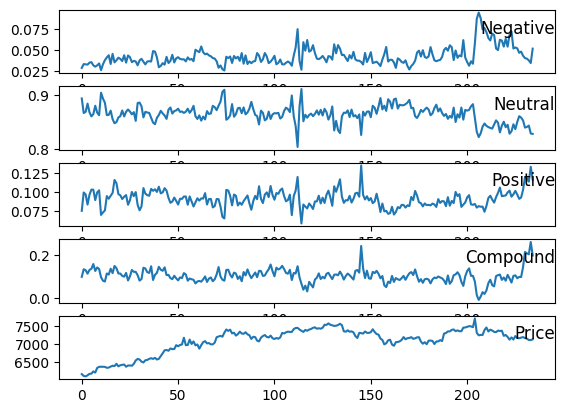

In [4]:
values = df1.values
# specify columns to plot
groups = [ 1,2,3,4,5]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df1.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [5]:
df1.set_index('DateTime',inplace=True)  #making DateTime as index. Because we are doing Time series Analysis
cols = df1.columns.tolist()
cols = cols[-1:] + cols[:-1]   #just making the price as the first column
df1 = df1[cols]
df1.head()

,Price,Negative,Neutral,Positive,Compound
DateTime,,,,,
2017-10-31T05:00:00.000Z,6158.76,0.028693,0.893468,0.075036,0.098252
2017-10-31T06:00:00.000Z,6105.90,0.033298,0.866806,0.099268,0.133432
2017-10-31T07:00:00.000Z,6094.36,0.032960,0.868896,0.096757,0.129065
2017-10-31T08:00:00.000Z,6125.13,0.032679,0.884061,0.083261,0.112910
2017-10-31T09:00:00.000Z,6165.00,0.035034,0.868187,0.096220,0.130149


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1)) #scaling values from 0 to 1
scaled = scaler.fit_transform(df1.values)

n_hours = 3
n_features = 5
n_obs = n_hours*n_features

reframed = series_to_supervised(scaled, n_hours, 1)  #t-3,t-2,t-1 values of all the columns. you can change n_hours for this
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,0.039567,0.044729,0.837460,0.218348,0.398397,0.007090,0.110680,0.586224,0.534241,0.529760,0.000000,0.105840,0.605920,0.501513,0.513454,0.018905,0.101818,0.748817,0.325570,0.453129
4,0.007090,0.110680,0.586224,0.534241,0.529760,0.000000,0.105840,0.605920,0.501513,0.513454,0.018905,0.101818,0.748817,0.325570,0.453129,0.043401,0.135554,0.599233,0.494515,0.517499
5,0.000000,0.105840,0.605920,0.501513,0.513454,0.018905,0.101818,0.748817,0.325570,0.453129,0.043401,0.135554,0.599233,0.494515,0.517499,0.046946,0.144279,0.528585,0.584308,0.538178
6,0.018905,0.101818,0.748817,0.325570,0.453129,0.043401,0.135554,0.599233,0.494515,0.517499,0.046946,0.144279,0.528585,0.584308,0.538178,0.085634,0.089063,0.566914,0.582236,0.619100
7,0.043401,0.135554,0.599233,0.494515,0.517499,0.046946,0.144279,0.528585,0.584308,0.538178,0.085634,0.089063,0.566914,0.582236,0.619100,0.065537,0.066399,0.712071,0.402359,0.499534


In [7]:
reframed = reframed.drop(reframed.columns[-4:], axis=1)  #dropping all the present values except present price
reframed.head()  #Note: here last column is present price which is our target variable

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
3,0.039567,0.044729,0.837460,0.218348,0.398397,0.007090,0.110680,0.586224,0.534241,0.529760,0.000000,0.105840,0.605920,0.501513,0.513454,0.018905
4,0.007090,0.110680,0.586224,0.534241,0.529760,0.000000,0.105840,0.605920,0.501513,0.513454,0.018905,0.101818,0.748817,0.325570,0.453129,0.043401
5,0.000000,0.105840,0.605920,0.501513,0.513454,0.018905,0.101818,0.748817,0.325570,0.453129,0.043401,0.135554,0.599233,0.494515,0.517499,0.046946
6,0.018905,0.101818,0.748817,0.325570,0.453129,0.043401,0.135554,0.599233,0.494515,0.517499,0.046946,0.144279,0.528585,0.584308,0.538178,0.085634
7,0.043401,0.135554,0.599233,0.494515,0.517499,0.046946,0.144279,0.528585,0.584308,0.538178,0.085634,0.089063,0.566914,0.582236,0.619100,0.065537


In [8]:
cols = reframed.columns.tolist()
cols = cols[-1:] + cols[:-1]   #just making the price as the first column
reframed = reframed[cols]
reframed.head()

,var1(t),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
3,0.018905,0.039567,0.044729,0.837460,0.218348,0.398397,0.007090,0.110680,0.586224,0.534241,0.529760,0.000000,0.105840,0.605920,0.501513,0.513454
4,0.043401,0.007090,0.110680,0.586224,0.534241,0.529760,0.000000,0.105840,0.605920,0.501513,0.513454,0.018905,0.101818,0.748817,0.325570,0.453129
5,0.046946,0.000000,0.105840,0.605920,0.501513,0.513454,0.018905,0.101818,0.748817,0.325570,0.453129,0.043401,0.135554,0.599233,0.494515,0.517499
6,0.085634,0.018905,0.101818,0.748817,0.325570,0.453129,0.043401,0.135554,0.599233,0.494515,0.517499,0.046946,0.144279,0.528585,0.584308,0.538178
7,0.065537,0.043401,0.135554,0.599233,0.494515,0.517499,0.046946,0.144279,0.528585,0.584308,0.538178,0.085634,0.089063,0.566914,0.582236,0.619100


In [9]:
from pyspark.ml.linalg import Vectors
reg_DF =sql.createDataFrame(reframed)
ad_df = reg_DF.rdd.map(lambda x: [Vectors.dense(x[1:]), x[0]]).toDF(['features', 'label'])
ad_df.show(5)

+--------------------+-------------------+
|            features|              label|
+--------------------+-------------------+
|[0.03956697509246...|0.01890490409309331|
|[0.00709010702743...|0.04340079379707795|
|[0.0,0.1058397702...|0.04694584731079798|
|[0.01890490409309...|0.08563423895012345|
|[0.04340079379707...| 0.0655374104520714|
+--------------------+-------------------+
only showing top 5 rows



In [10]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol = 'label')

In [11]:
lr_model = lr.fit(ad_df)

In [12]:
predictions = lr_model.transform(ad_df)
someDF = predictions.select("prediction", "label").show(5)

+--------------------+-------------------+
|          prediction|              label|
+--------------------+-------------------+
|0.028620834644727006|0.01890490409309331|
| 0.03132315363382637|0.04340079379707795|
| 0.05880438581866115|0.04694584731079798|
| 0.06919143529005507|0.08563423895012345|
| 0.09122043662870438| 0.0655374104520714|
+--------------------+-------------------+
only showing top 5 rows



In [13]:
predictions = predictions.toPandas().head()

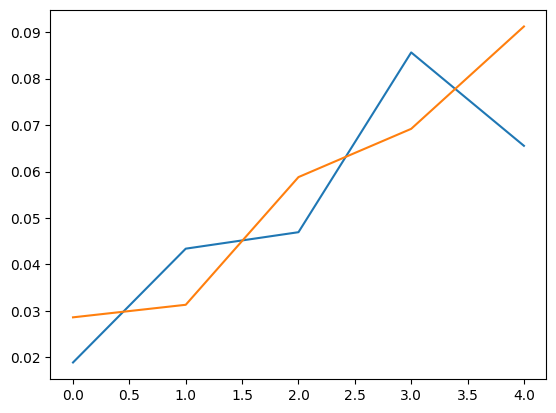

In [14]:
plt.plot(predictions['label'])
plt.plot(predictions['prediction'])
plt.show()

In [15]:
print("Coefficients: %s" % str(lr_model.coefficients))
print("Intercept: %s" % str(lr_model.intercept))

Coefficients: [0.07184779048762702,0.016634653888693576,-0.01860978625435247,-0.02163801614331683,-0.00681041885025938,0.12368014881147509,0.010016611420777572,-0.06714804982921481,-0.10913272834938788,0.0851468570475602,0.7724495061814552,-0.15954310406735586,-0.040591769563837296,0.0695222130561235,-0.16320757533432215]
Intercept: 0.18904547121506593
